### Install DeepTMpred and ESM

In [ ]:
!git clone https://github.com/ISYSLAB-HUST/DeepTMpred.git
!pip install -r ./DeepTMpred/requirements.txt
!pip install fair-esm
import os
os.chdir('./DeepTMpred')
!sh ./script/download.sh

### Batch Sequence Prediction Mode
Very suitable for large-scale prediction TMPs for users, users can use CUDA mode to improve the speed of prediction

In [34]:
!python ./tmh_main.py /content/DeepTMpred/model_files/deepTMpred-b.pth /content/DeepTMpred/model_files/orientaion-b.pth ./notebook/test.fa

### Single Sequence Prediction Mode
This approach provides good visualization and support for sequence position options for signal peptides

Topology:
╒═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│ TMH-1   │ TMH-2   │ TMH-3   │ TMH-4   │ TMH-5   │ TMH-6   │ TMH-7   │ TMH-8   │ TMH-9   │ TMH-10   │ TMH-11   │ TMH-12   │ TMH-13   │ TMH-14   │
╞═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ 16-39   │ 56-78   │ 86-105  │ 110-130 │ 151-172 │ 178-198 │ 232-252 │ 257-277 │ 298-324 │ 338-359  │ 375-396  │ 405-426  │ 442-463  │ 485-503  │
╘═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧══════════╧══════════╧══════════╧══════════╧══════════╛
The probability of protein:


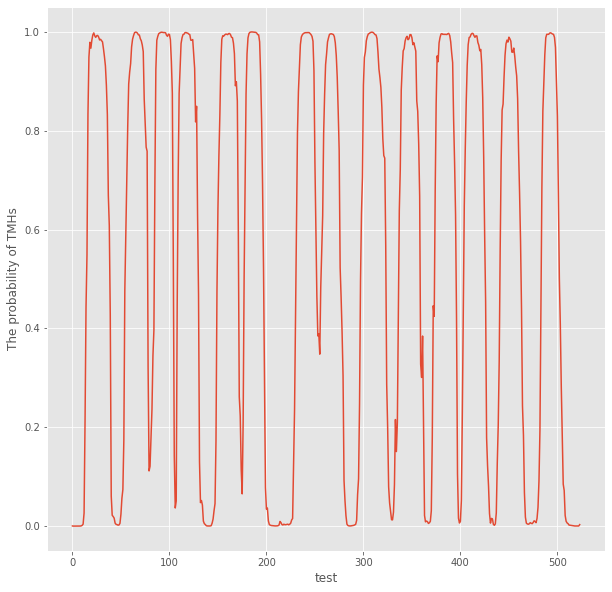

In [33]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
query_sequence = 'MNSPVDAPKWPRQIPYIIASEACERFSFYGMRNILTPFLMTALLLSIPEELRGAVAKDVFHSFVIGVYFFPLLGGWIADRFFGKYNTILWLSLIYCVGHAFLAIFEHSVQGFYTGLFLIALGSGGIKPLVSSFMGDQFDQSNKSLAQKAFDMFYFTINFGSFFASLSMPLLLKNFGAAVAFGIPGVLMFVATVFFWLGRKRYIHMPPEPKDPHGFLPVIRSALLTKVEGKGNIGLVLALIGGVSAAYALVNIPTLGIVAGLCCAMVLVMGFVGAGASLQLERARKSHPDAAVDGVRSVLRILVLFALVTPFWSLFDQKASTWILQANDMVKPQWFEPAMMQALNPLLVMLLIPFNNFVLYPAIERMGVKLTALRKMGAGIAITGLSWIVVGTIQLMMDGGSALSIFWQILPYALLTFGEVLVSATGLEFAYSQAPKAMKGTIMSFWTLSVTVGNLWVLLANVSVKSPTVTEQIVQTGMSVTAFQMFFFAGFAILAAIVFALYARSYQMQDHYRQATGSENLYFQ' #@param {type:"string"}
#@markdown  - Enter the sequence of the TMPs, which can include part of the signal peptide
query_ID = 'test' #@param {type:"string"}
signal_peptide_position = 0 #@param {type:"integer"}
#@markdown  - It is recommended to use [SignalP](https://services.healthtech.dtu.dk/service.php?SignalP-6.0) to predict the position of the signal peptide
import os
output_dir = os.path.join('.', query_ID+'_result')
os.makedirs(output_dir, exist_ok=True)
with open(os.path.join(output_dir,query_ID+'.fa'), 'w') as fw:
    fw.write('>' + query_ID + '\n' + query_sequence)

import json
import sys

import torch
import esm
from deepTMpred.model import FineTuneEsmCNN, OrientationNet
from deepTMpred.utils import tmh_predict
from torch.utils.data import DataLoader
from deepTMpred.data import FineTuneDataset, batch_collate


def data_iter(data_path, pssm_dir, hmm_dir, batch_converter, label=False):
    data = FineTuneDataset(data_path, pssm_dir=pssm_dir, hmm_file=hmm_dir, label=label)
    test = DataLoader(data, len(data), collate_fn=batch_collate(batch_converter, label=label))
    return test


def test(model, orientation_model, test_loader, device):
    model.eval()
    with torch.no_grad():
        for tokens, _ids, matrix, token_lengths in test_loader:
            tokens = tokens.to(device)
            results = model.esm(tokens, repr_layers=[12], return_contacts=False)
            token_embeddings = results["representations"][12][:, 1:, :]
            token_lengths = token_lengths.to(device)
            matrix = matrix.to(device)
            embedings = torch.cat((matrix, token_embeddings), dim=2)
            predict_list, prob = model.predict(embedings, token_lengths)
            orientation_out = orientation_model(embedings)
            predict = torch.argmax(orientation_out, dim=1)
            tmh_dict = tmh_predict(_ids, predict_list, prob, predict.tolist())
    return tmh_dict



###############
test_file = os.path.join(output_dir,query_ID+'.fa')
tmh_model_path = './model_files/deepTMpred-b.pth'
orientation_model_path = "./model_files/orientaion-b.pth"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
###############

model = FineTuneEsmCNN(768)
pretrain_model, alphabet = esm.pretrained.esm1_t12_85M_UR50S()
batch_converter = alphabet.get_batch_converter()
model.add_module('esm', pretrain_model.to(device))
model.load_state_dict(torch.load(tmh_model_path))
model = model.to(device)

orientation_model = OrientationNet()
orientation_model.load_state_dict(torch.load(orientation_model_path))
orientation_model = orientation_model.to(device)

test_iter = data_iter(test_file, None, None, batch_converter, label=False)
tmh_dict = test(model, orientation_model, test_iter, device)
json.dump(tmh_dict, open(os.path.join(output_dir, query_ID+'.json'), 'w'))

import json
import matplotlib.pyplot as plt
test = json.load(open(os.path.join(output_dir, query_ID+'.json')))
proba = [0] * signal_peptide_position + test[query_ID]['topo_proba'][signal_peptide_position:]
topo = test[query_ID]['topo']
topo_remove = []
for item in topo:
    if item[0]-1 > signal_peptide_position:
        topo_remove.append(item)
if len(topo_remove) == 0:
    print('### Transmembrane residues found: 0, \n### This looks like a soluble protein.')
else:
    from tabulate import tabulate
    print("Topology:")
    _table_topo =  [[f"{item[0]}-{item[1]}" for item in topo_remove]]
    print(tabulate(_table_topo,headers=['TMH-'+ str(i+1) for i in range(len(topo_remove))], tablefmt='fancy_grid'))
print("The probability of protein:")
plt.style.use('ggplot')
plt.figure(figsize=(10,10))
plt.plot(proba)
plt.xlabel(query_ID)
plt.ylabel("The probability of TMHs")
plt.savefig(os.path.join(output_dir, 'test.png'), dpi=600)

In [39]:
#@title Download results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://tvax4.sinaimg.cn/large/005vYU31ly1h0m1wtexv4j30hu0r7jv6.jpg)).
from google.colab import files
import zipfile
 
 
def zipDir(dirpath, outFullName):
    zip = zipfile.ZipFile(outFullName, "w", zipfile.ZIP_DEFLATED)
    for path, dirnames, filenames in os.walk(dirpath):
        # 去掉目标跟路径，只对目标文件夹下边的文件及文件夹进行压缩
        fpath = path.replace(dirpath, '')
 
        for filename in filenames:
            zip.write(os.path.join(path, filename), os.path.join(fpath, filename))
    zip.close()
zipDir(output_dir, f"{query_ID}.result.zip")
files.download(f"{query_ID}.result.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>